In [3]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import numpy as np
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
import joblib

# data frame below has all states data for 2021

- individuals with annual income > 200k and occupation not in the top 250 bin buckets are filtered out
- Then the categorical features: COW, SCHL, SEX, MAR, OCCP, RAC1P
- Numeric features: AGEP, WKHP and target PINCP are min max scaled
- For more details on how the dataframe below is processed check out **example_dataprocessing.ipynb** 

# In case this doesnt fit in your machine's memory try working with smaller state list

The pipeline is as follows

1) Load the dataframe, process and scale like in **example_dataprocessing.ipynb**
2) Compute Adanormal hedge, online ridge performances like in **examplemain_AnhvsORidge_all.ipynb** and **very important save the pickle files**
3) Plot using this notebook **plotting_AnhvsORidge_results.ipynb**

TODO
1) Online ridge on subsequences, kind of lower bound? (DONE was already computed in Anh.experts[gnum].loss_tarr
2) Add meta expert to Anh which has an expert active always (DONE but with all features available still)
3) Group membership for different models? What features presented to the algorithm; 
    -remove group membership as features for all algorithms and test performnace of Anh vs Online ridge
4) Weights for online ridge

In [4]:
df_all = pd.read_pickle("allstates2021.pkl") 

In [5]:
df_all

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,SEX_2,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
0,0.025316,0.295918,0.039472,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0.037975,0.397959,0.030967,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.025316,0.173469,0.030467,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0.215190,0.051020,0.053479,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0.025316,0.091837,0.009455,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,0.291139,0.397959,0.399670,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1630163,0.379747,0.397959,0.299615,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1630164,0.367089,0.397959,0.092501,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1630165,0.063291,0.295918,0.060483,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
len(df_all)

1428283

In [6]:
df_all.dtypes # only AGEP, WKHP, PINCP are numeric, rest are ints (one hot encoded)

AGEP       float64
WKHP       float64
PINCP      float64
COW_1        uint8
COW_2        uint8
            ...   
RAC1P_5      uint8
RAC1P_6      uint8
RAC1P_7      uint8
RAC1P_8      uint8
RAC1P_9      uint8
Length: 301, dtype: object

In [7]:
X_dat = df_all.drop('PINCP', axis=1) #dropping the income column
y_dat = pd.DataFrame(df_all['PINCP']) # picking up only the income column for the target

In [8]:
gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9'] #sensitive group names
sensitive_group_cols = X_dat[gnames] # this picks the above columns from X_dat dataframe
A_tarr = sensitive_group_cols.to_numpy()

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
N = A_tarr.shape[1] # number of meta-experts
d = len(X_dat.columns) # dimensionality of features
T = len(X_dat) # number of rounds of interaction, basically # of rows of data
print(N, d, T)

11 300 1428283


**Load Adanormal hedge object** which ran with N meta experts each of which is a online ridge regression object with l2 penalty = 1.0

Online Ridge in Azoury, Warmouth (concise ref in Kakade and Foster, Calibration via regression) 

In [12]:
with open('Anh_all_with_cumreg.pkl', 'rb') as f:
    Anh = pickle.load(f)

**Load best square loss** in hinsight for each group subsequence, this is calculated using online least squares for each subsequence

In [9]:
with open('bestsqloss_hindsight_all.pkl', 'rb') as f: #best least squares loss for each subsequence
    bestsqloss_list = pickle.load(f)

# The 3 code blocks below calculate the groupwise regret of an online ridge learner which is active in each round

In [16]:
bestsqloss_arr = [obj.best_sqloss for obj in bestsqloss_list] # array of size N and each element has size Tg i.e. its group subsequence length

NameError: name 'bestsqloss_list' is not defined

In [14]:
# with open('model_oridge_all_alwaysactive.pkl', 'rb') as f:
#     model_oridge_baseline = pickle.load(f)

with open('loss_oridge_all_alwaysactive.pkl', 'rb') as f:
    loss_tarr = pickle.load(f)

In [14]:
loss_groupwise_oridge = []
cumloss_groupwise_oridge = []
cumreg_groupwise_oridge = []
loss_oridge_tarr = np.array(loss_tarr)

for gnum in range(N): # build cumulative loss for  on each group subsequence
    loss_groupwise_oridge.append(loss_oridge_tarr[A_tarr[:, gnum].astype(bool)]) # select those losses where group gnum active
    cumloss_groupwise_oridge.append(np.cumsum(loss_groupwise_oridge[-1])) #cumulative sum of the previous
    cumreg_groupwise_oridge.append(cumloss_groupwise_oridge[-1] - np.array(bestsqloss_arr[gnum])) #bestsquare loss for that group subsequence still the same

NameError: name 'loss_tarr' is not defined

# The following code block finds regret for Online ridge on group subsequence 
(the non implementable version)

In [15]:
cumloss_groupwise_ridgesubseq = []
cumreg_groupwise_ridgesubseq = []

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - np.array(bestsqloss_arr[gnum])) #bestsquare loss for that group subsequence still the same

NameError: name 'bestsqloss_arr' is not defined

In [17]:
# Plotting code:

def plot_Anh(Anh):
    '''
    Anh: is Adanormal_sleepingexps object
    '''
    for gnum in range(N):
        Tg = Anh.experts[gnum].time # number of rounds this group is active
        Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
        print(f'''Group number {gnum}, Tg is {Tg}, Anh end regret {Anh_end:.2f}''')
        time_steps = np.arange(1, Tg+1)
        plt.plot(time_steps, Anh.cuml_regret_curve[gnum])
        plt.xlabel("Time slots")
        plt.ylabel("Regret")
        plt.show()

# plotting Online Ridge active in all rounds vs Ada normal hedge
def plot_ORidgevsAnh(cumreg_groupwise_oridge, Anh):
    '''
    cumreg_groupwise_oridge (List):  is the cumulative regret for online ridge which is always active
    Anh (object): is Adanormal_sleepingexps 
    '''
    Anhbetter_count = 0
    for gnum in range(len(cumreg_groupwise_oridge)):  
        oridge_regret_g = cumreg_groupwise_oridge[gnum]
        Tg = len(oridge_regret_g) # number of rounds this group is active
        Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
        oridge_end = oridge_regret_g[-1]
        
        if  Anh_end <= oridge_end:
          Anhst = "Yes"
          Anhbetter_count += 1
        else:
          Anhst = "No"
        
        print(f'''Group number {gnum}, Tg is {Tg} \n
                oridge end regret {oridge_end:.2f}, Anh end regret {Anh_end:.2f}, \n
              Anh better {Anhst} ''')
        time_steps = np.arange(1, Tg+1)
        fig, axes = plt.subplots(nrows=1, ncols=2)
        
        axes[0].title.set_text('Online ridge ignoring groups')
        axes[1].title.set_text('AdaNormal hedge')
        axes[0].plot(time_steps, cumreg_groupwise_oridge[gnum])
        axes[1].plot(time_steps, Anh.cuml_regret_curve[gnum])
        
        plt.xlabel("Time slots")
        plt.ylabel("Regret")
        plt.show()
    print(f'Anh better for {Anhbetter_count} out of {N} groups')
    

In [18]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  for gnum in range(len(cumreg_groupwise_oridge)):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end:.2f}, Anh end regret {Anh_end:.2f}, \n
    Anh better {Anhst} ''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups')

def plot_perstepavg_allgroups(cumreg_groupwise_oridge, Anh):
  plt.xlabel("Time slots")
  plt.ylabel("Regret")
  # for gnum in range(len(cumreg_groupwise_oridge)):  
  for gnum in range(2):
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    # Anh_curve = Anh.cuml_regret_curve[gnum] # Anh curve for this group
    time_steps = np.arange(1, Tg+1)
    # plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'--', label = f"Online Ridge (OR) {gnum}")
    # plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-', label = f"Anh{gnum}")
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum] / time_steps,'--', label = f"Online Ridge average (OR) {gnum}")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum] / time_steps ,'-', label = f"Anh average{gnum}")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()
  # def compute_per_stepavg():
  #   '''
  #     Computes per step average for each of the groups for both the single online ridge and Adanormalhedge
  #   '''
    
  #   return  oridge_avgreg_perstep_list, Anh_avgreg_perstep_list
  



In [35]:
print(np.array([2,4,8])/ np.arange(1, 4))
print(np.arange(1, 4))
print(8/3)

[2.         2.         2.66666667]
[1 2 3]
2.6666666666666665


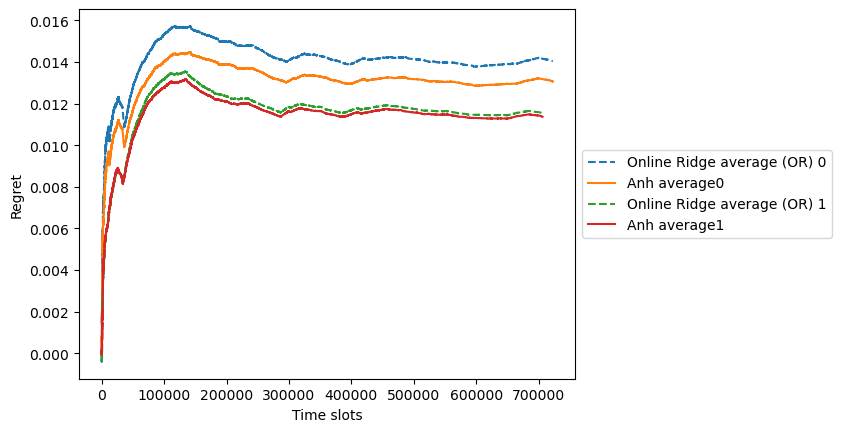

In [23]:
plot_perstepavg_allgroups(cumreg_groupwise_oridge, Anh)

# We have everything required to display the side by side comparison of the 2 algorithms

Group number 0, Tg is 722240 

    oridge end regret 10137.96, Anh end regret 9436.61, 

    Anh better Yes 


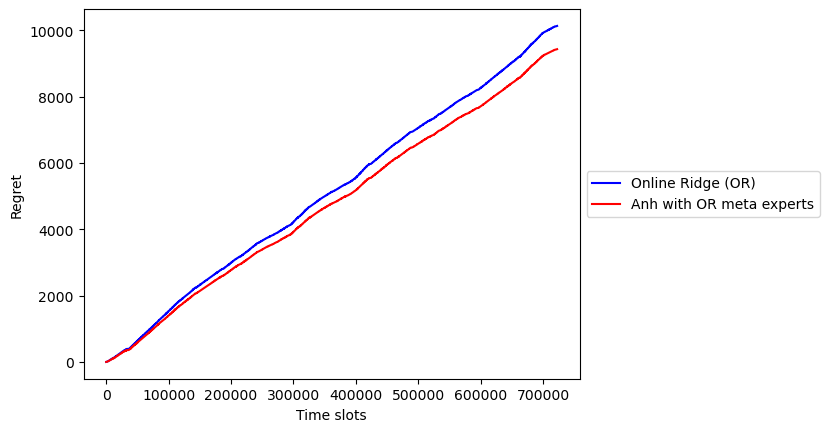

Group number 1, Tg is 706043 

    oridge end regret 8138.95, Anh end regret 8026.01, 

    Anh better Yes 


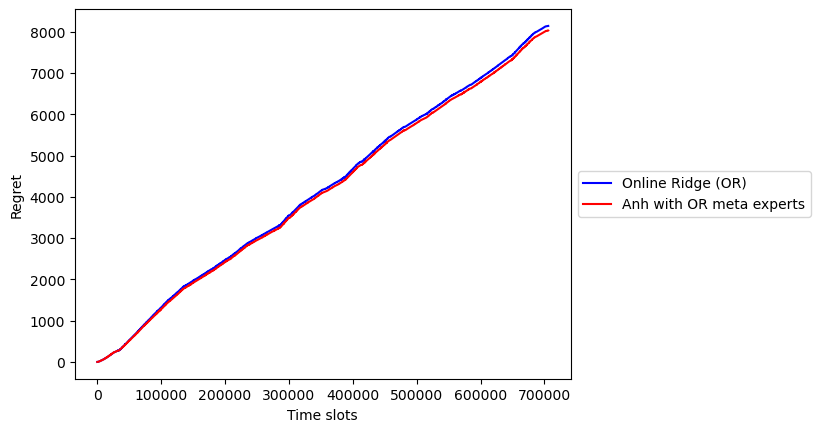

Group number 2, Tg is 948630 

    oridge end regret 12603.57, Anh end regret 12126.52, 

    Anh better Yes 


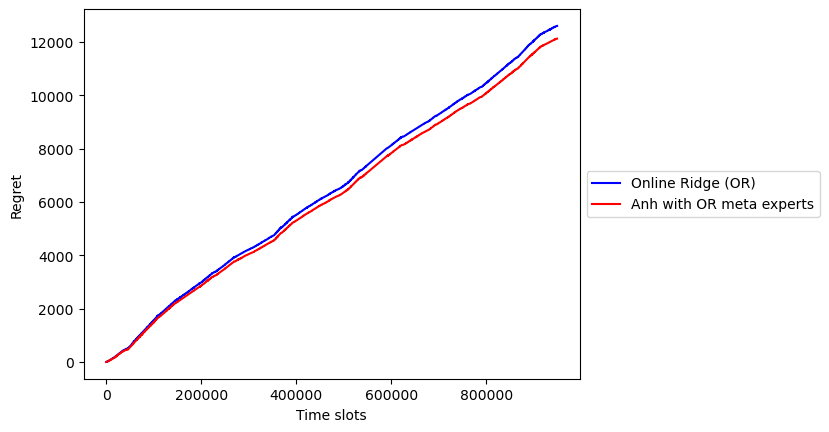

Group number 3, Tg is 124853 

    oridge end regret 989.60, Anh end regret 976.68, 

    Anh better Yes 


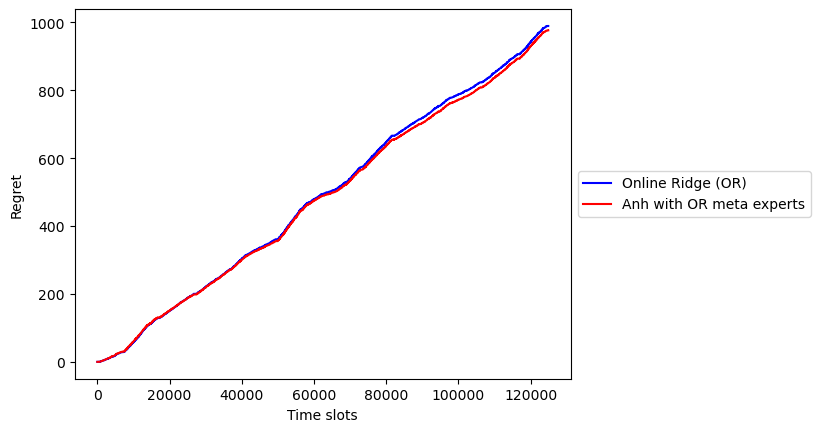

Group number 4, Tg is 13066 

    oridge end regret 83.91, Anh end regret 71.86, 

    Anh better Yes 


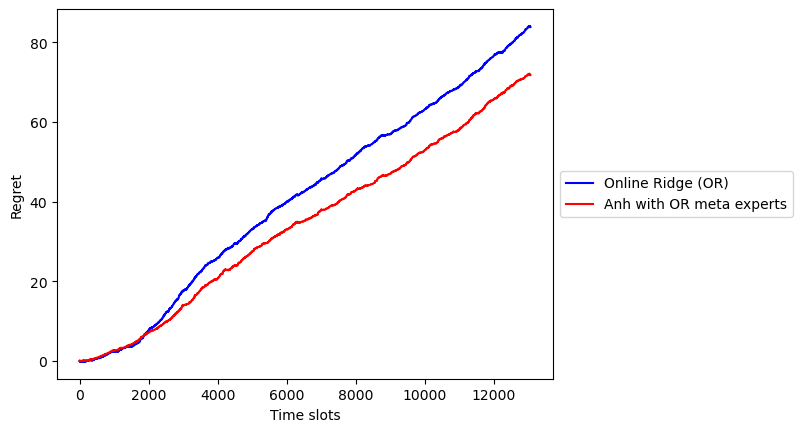

Group number 5, Tg is 613 

    oridge end regret 1.17, Anh end regret 1.41, 

    Anh better No 


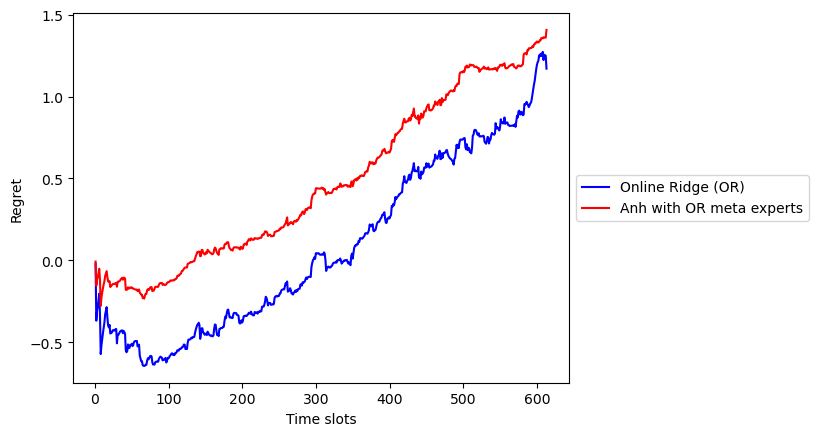

Group number 6, Tg is 2110 

    oridge end regret 10.50, Anh end regret 7.77, 

    Anh better Yes 


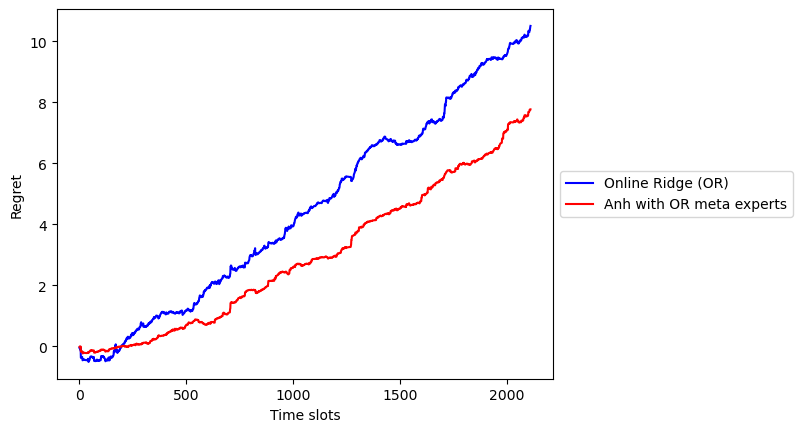

Group number 7, Tg is 92707 

    oridge end regret 1894.51, Anh end regret 1757.44, 

    Anh better Yes 


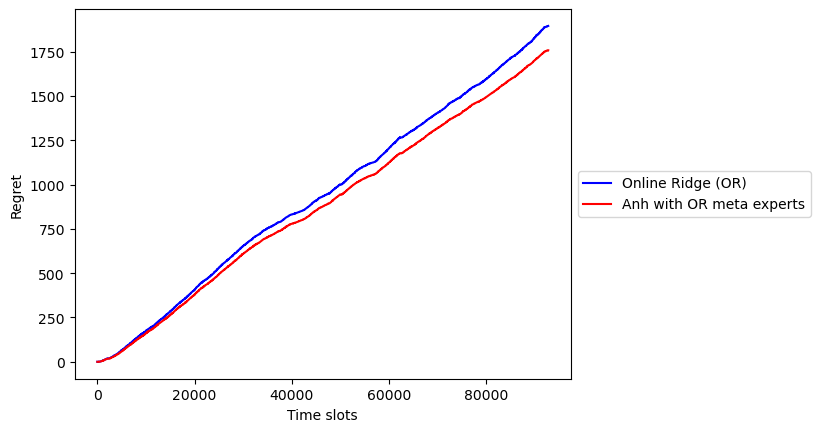

Group number 8, Tg is 2486 

    oridge end regret 8.76, Anh end regret 8.72, 

    Anh better Yes 


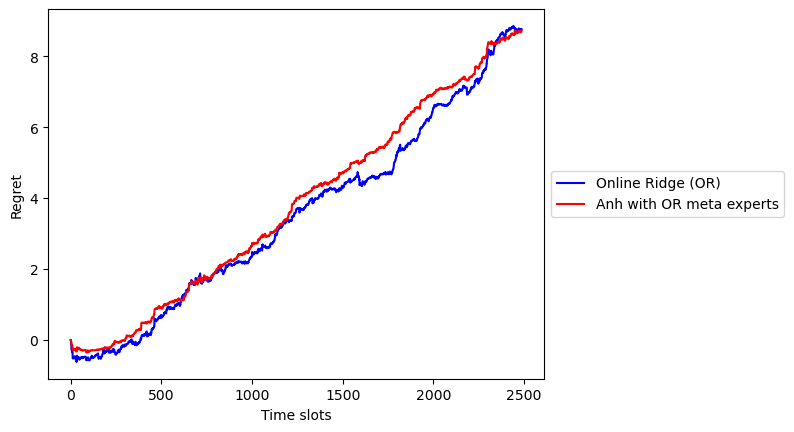

Group number 9, Tg is 89974 

    oridge end regret 769.64, Anh end regret 600.97, 

    Anh better Yes 


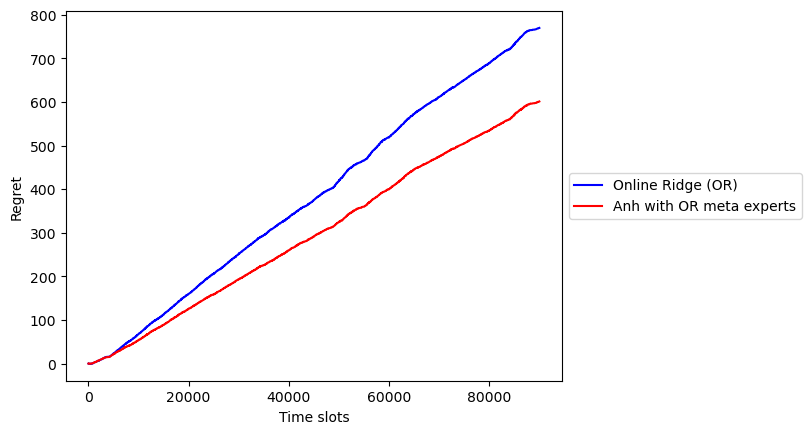

Group number 10, Tg is 153844 

    oridge end regret 1693.88, Anh end regret 1689.89, 

    Anh better Yes 


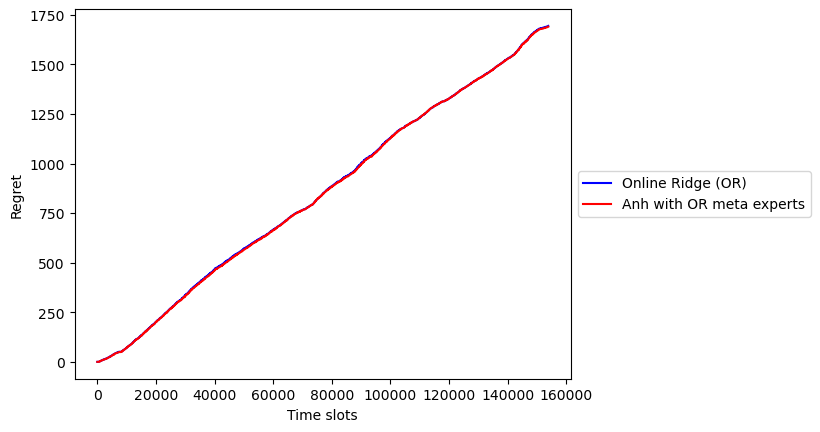

Anh better for 10 out of 11 groups


In [46]:
plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh)

Group number 0, Tg is 722240 

    oridge end regret 9437.46, Anh end regret 9436.61, 

    Anh better Yes 


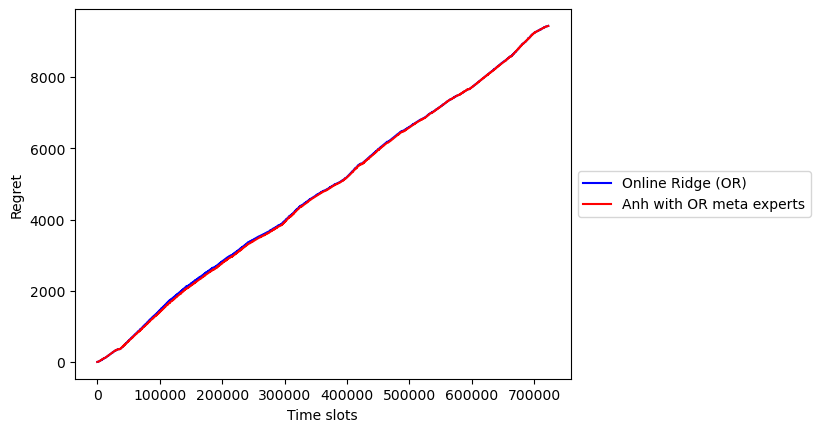

Group number 1, Tg is 706043 

    oridge end regret 8167.72, Anh end regret 8026.01, 

    Anh better Yes 


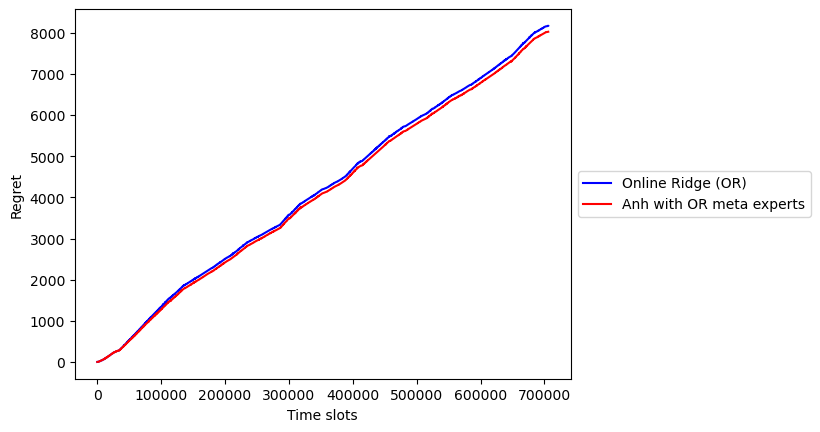

Group number 2, Tg is 948630 

    oridge end regret 12378.26, Anh end regret 12126.52, 

    Anh better Yes 


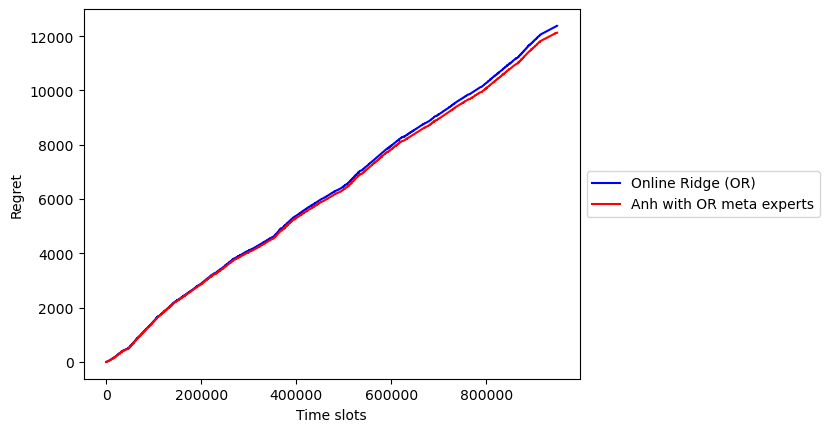

Group number 3, Tg is 124853 

    oridge end regret 977.35, Anh end regret 976.68, 

    Anh better Yes 


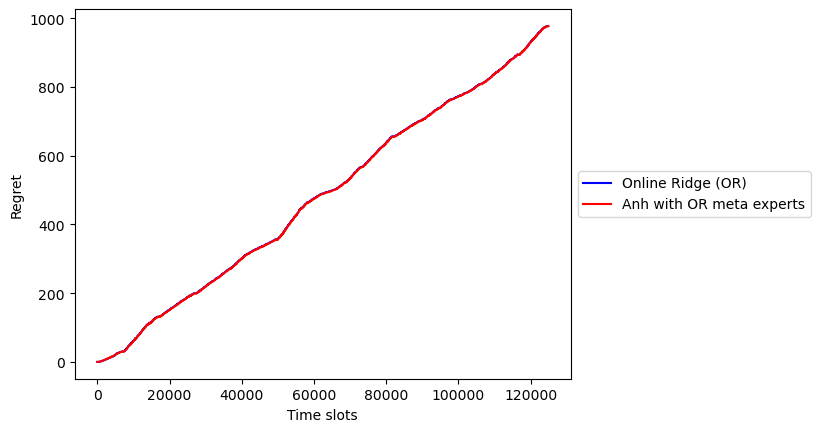

Group number 4, Tg is 13066 

    oridge end regret 71.09, Anh end regret 71.86, 

    Anh better No 


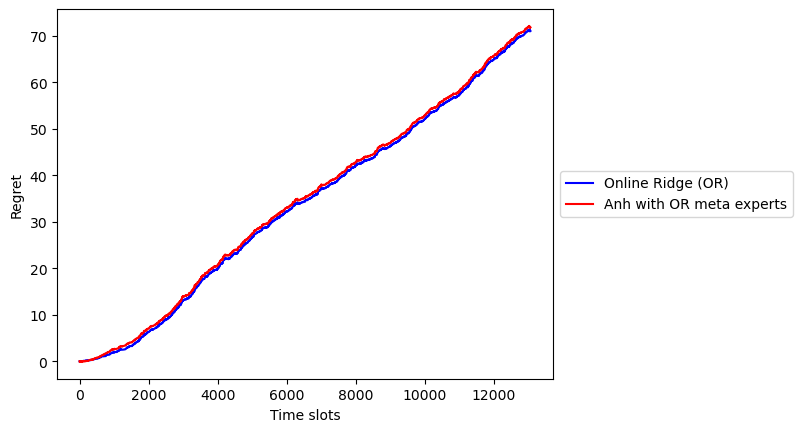

Group number 5, Tg is 613 

    oridge end regret 1.25, Anh end regret 1.41, 

    Anh better No 


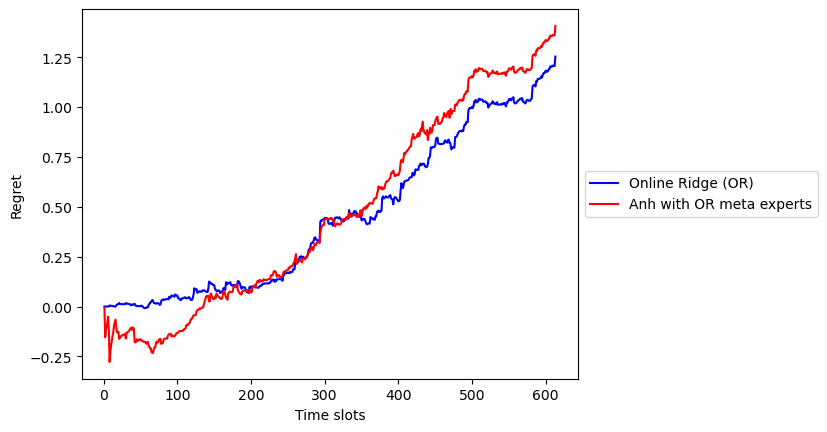

Group number 6, Tg is 2110 

    oridge end regret 7.99, Anh end regret 7.77, 

    Anh better Yes 


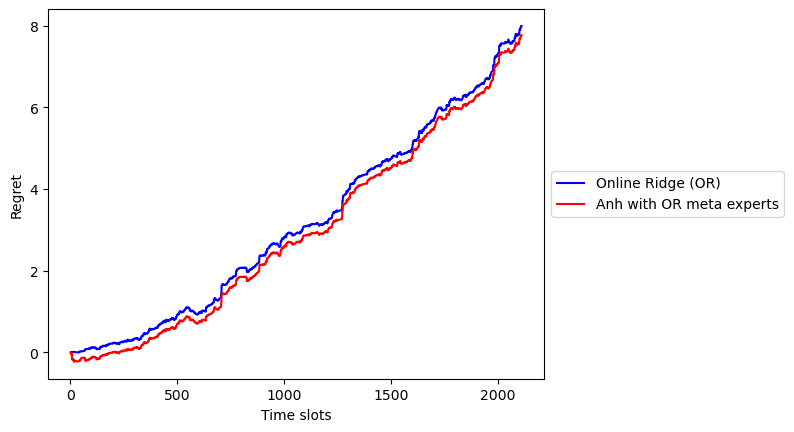

Group number 7, Tg is 92707 

    oridge end regret 1756.06, Anh end regret 1757.44, 

    Anh better No 


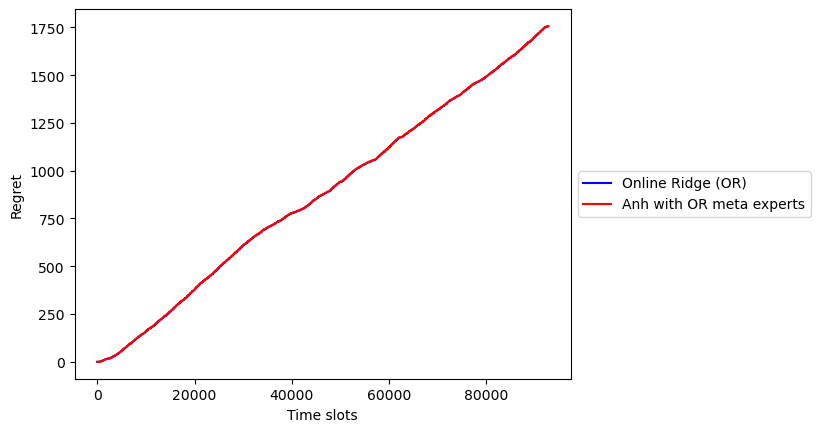

Group number 8, Tg is 2486 

    oridge end regret 9.01, Anh end regret 8.72, 

    Anh better Yes 


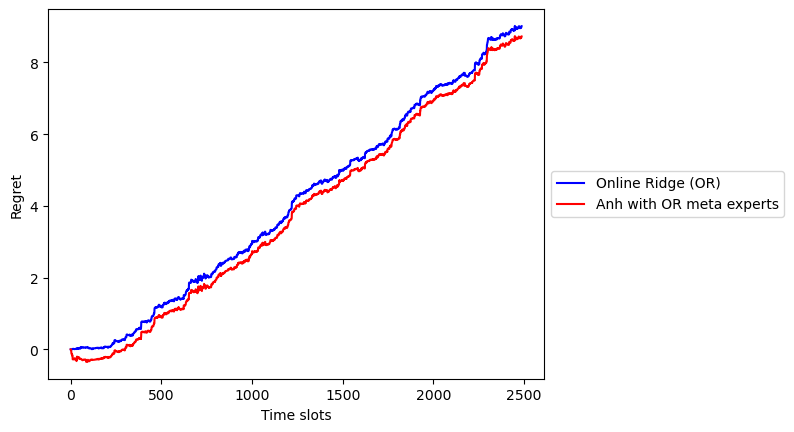

Group number 9, Tg is 89974 

    oridge end regret 599.45, Anh end regret 600.97, 

    Anh better No 


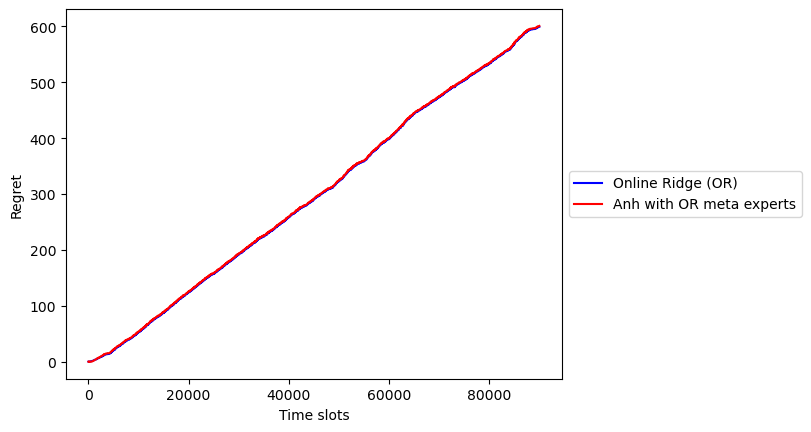

Group number 10, Tg is 153844 

    oridge end regret 1697.53, Anh end regret 1689.89, 

    Anh better Yes 


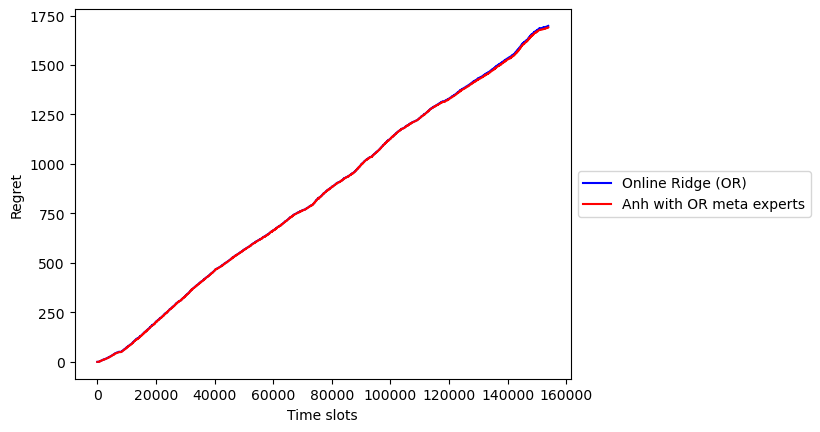

Anh better for 7 out of 11 groups


In [20]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh) # this plot is for Anh vs Online ridge for each subsequence

In [23]:
print(bestsqloss_arr[0].shape)
print(len(Anh.experts[0].loss_tarr))

(722240,)
722240


# Now lets compare performance of Anh with an extra always active group vs Online ridge on subsequences


In [13]:
N = Anh_plusone.N
print(N)

12


In [26]:
X_dat = df_all.drop('PINCP', axis=1) #dropping the income column
y_dat = pd.DataFrame(df_all['PINCP']) # picking up only the income column for the target

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9'] #sensitive group names
sensitive_group_cols = X_dat[gnames] # this picks the above columns from X_dat dataframe
A_tarr = sensitive_group_cols.to_numpy()

print(A_tarr.shape) # has the 11 groups already, now to add the always active group
sensitive_group_cols = X_dat[gnames]
sensitive_group_cols['always_on'] = 1
A_tarr_plus = sensitive_group_cols.to_numpy()
print(A_tarr_plus.shape)

(1428283, 11)
(1428283, 12)


/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_95453/2989226154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitive_group_cols['always_on'] = 1


In [67]:
#Anh with always active vs online ridge
with open('Anh_plus_alwaysactive.pkl', 'rb') as f:
    Anh_plusone = pickle.load(f)

In [62]:
with open('bestsqlosslist_11groups_plusalwaysactive.pkl', 'rb') as f: #best least squares loss for each subsequence
    bestsqloss_list = pickle.load(f)

In [56]:
#bestsqloss_arr = [obj.best_sqloss for obj in bestsqloss_list] # array of size N and each element has size Tg i.e. its group subsequence length

In [68]:
bls_undrop = joblib.load('bls_together_undroppedjoblib.pkl') # new object, smaller in memory

In [ ]:
bls_undrop.best_sqloss

In [70]:
print(N)

12


In [59]:
# cumloss_groupwise_ridgesubseq = []
# cumreg_groupwise_ridgesubseq = []

# for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
#     cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_plusone.experts[gnum].loss_tarr))
#     cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - np.array(bestsqloss_arr[gnum])) #bestsquare loss for that group subsequence still the same

In [71]:
cumloss_groupwise_ridgesubseq = [] # for the new object, bls
cumreg_groupwise_ridgesubseq = [] # finding regret for oridge experts

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_plusone.experts[gnum].loss_tarr))
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_undrop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [ ]:
# bestsqloss_arr = [obj.best_sqloss for obj in bestsqloss_list] # TODO change, this is just a hack to make it compatabile with old style

In [74]:
Anh_plusone.build_cumloss_curve(bls_undrop.best_sqloss, A_tarr_plus)

Group number 0, Tg is 722240 

    oridge end regret 9437.46, Anh end regret 9436.65, 

    Anh better Yes 


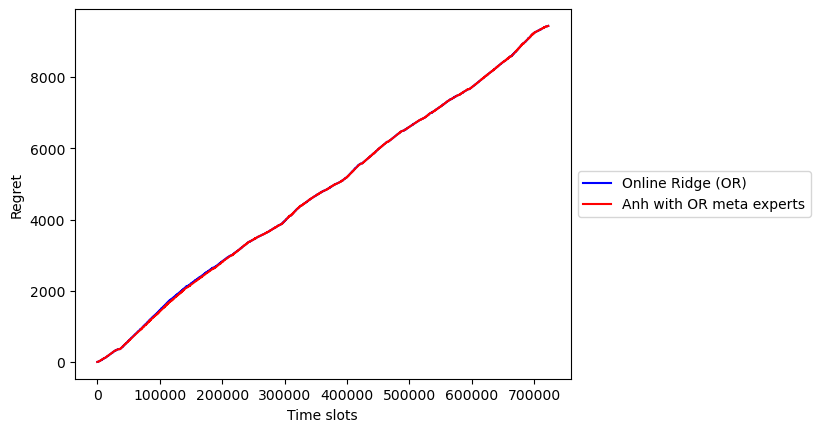

Group number 1, Tg is 706043 

    oridge end regret 8167.72, Anh end regret 8015.68, 

    Anh better Yes 


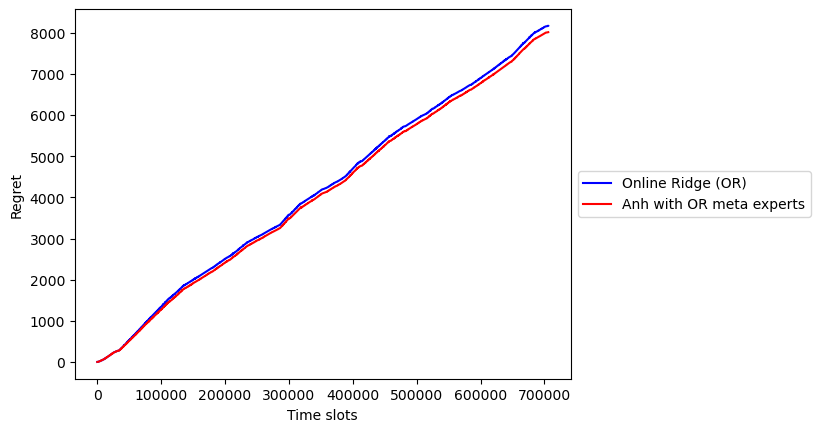

Group number 2, Tg is 948630 

    oridge end regret 12378.26, Anh end regret 12108.70, 

    Anh better Yes 


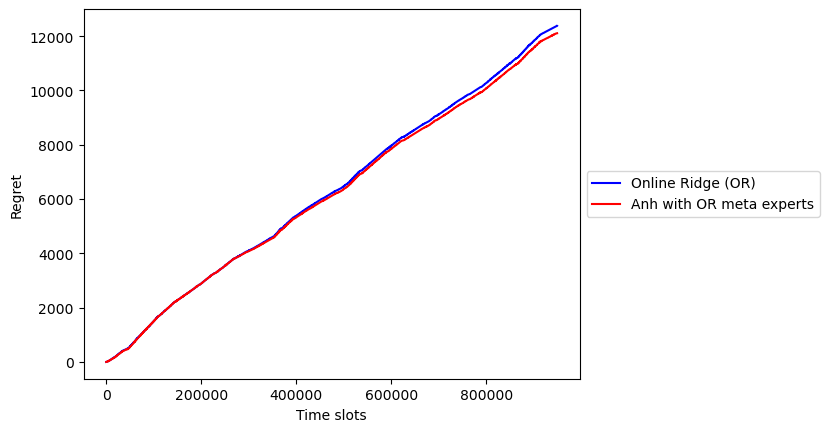

Group number 3, Tg is 124853 

    oridge end regret 977.35, Anh end regret 977.09, 

    Anh better Yes 


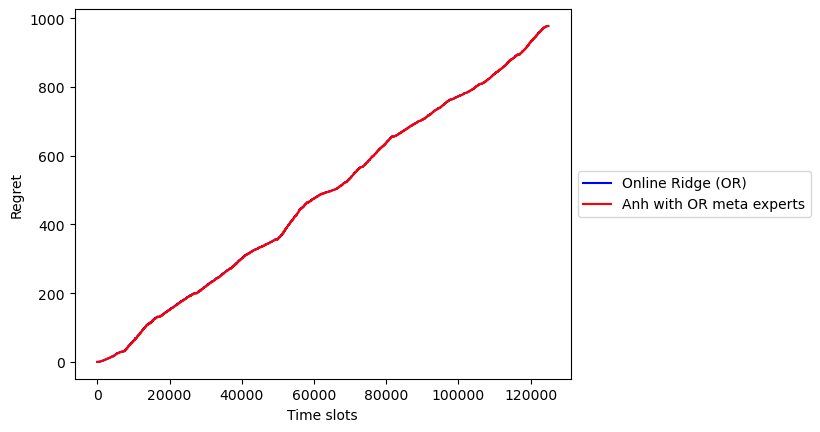

Group number 4, Tg is 13066 

    oridge end regret 71.09, Anh end regret 71.85, 

    Anh better No 


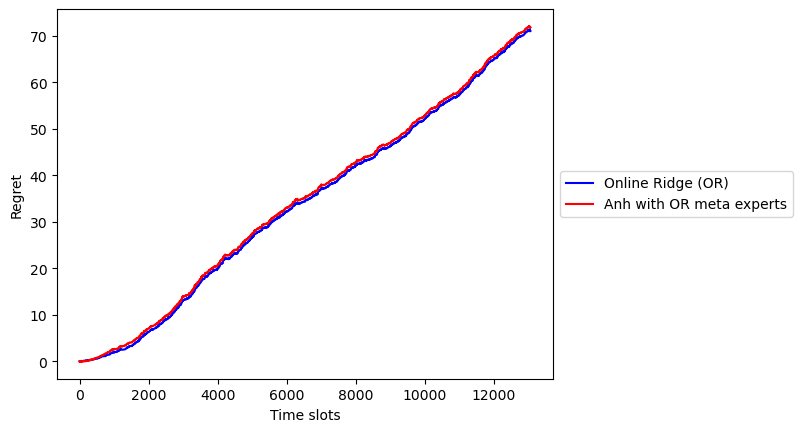

Group number 5, Tg is 613 

    oridge end regret 1.25, Anh end regret 1.42, 

    Anh better No 


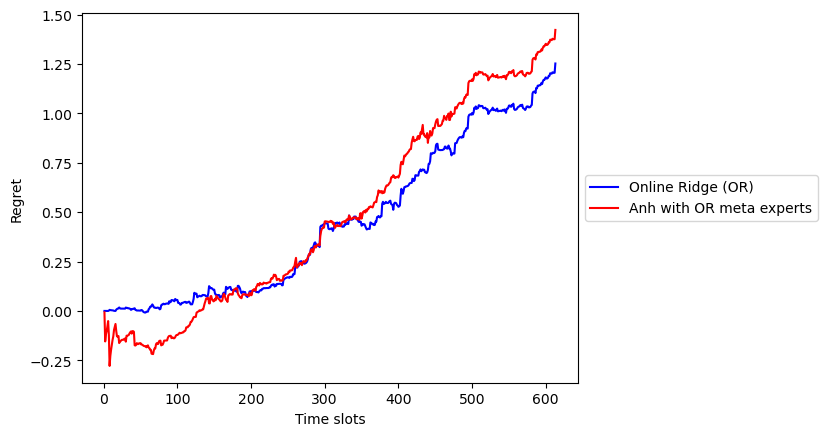

Group number 6, Tg is 2110 

    oridge end regret 7.99, Anh end regret 7.77, 

    Anh better Yes 


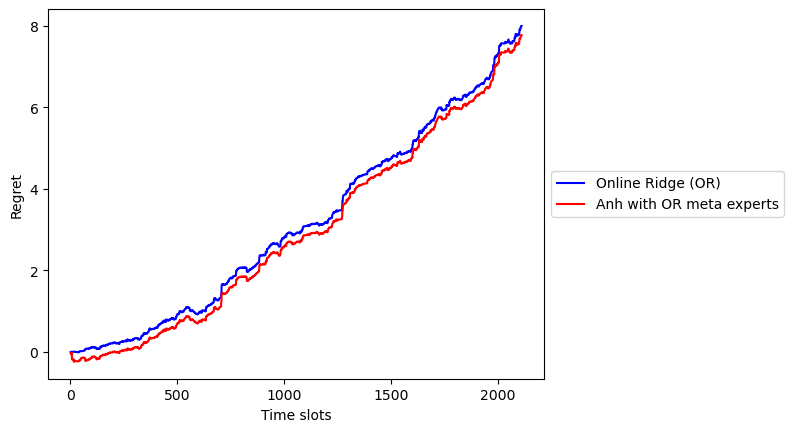

Group number 7, Tg is 92707 

    oridge end regret 1756.06, Anh end regret 1757.50, 

    Anh better No 


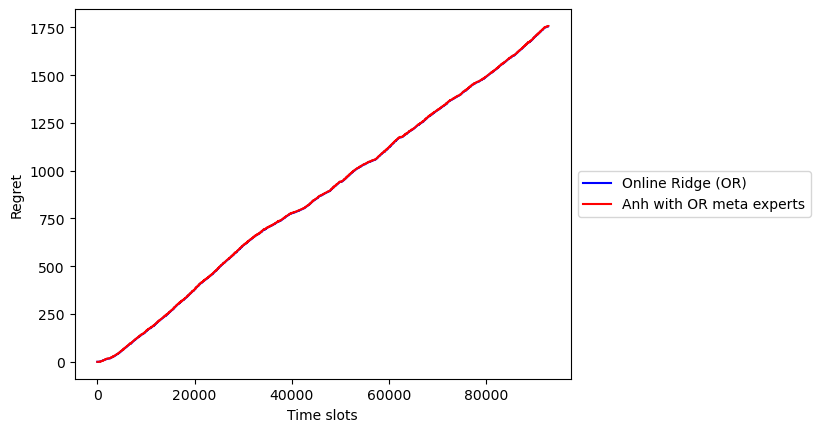

Group number 8, Tg is 2486 

    oridge end regret 9.01, Anh end regret 8.75, 

    Anh better Yes 


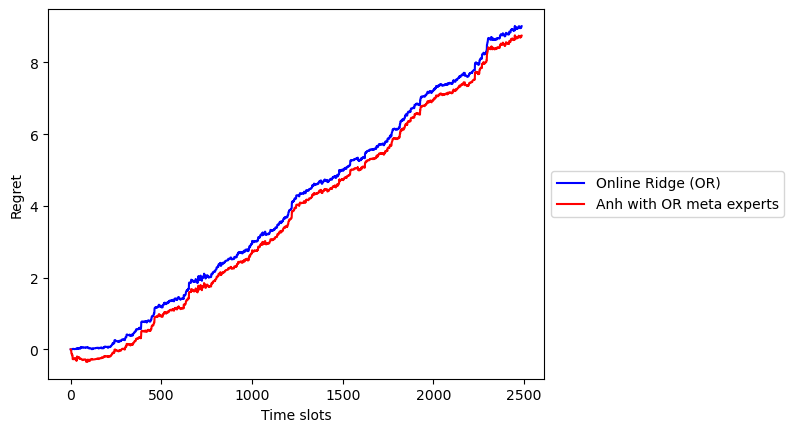

Group number 9, Tg is 89974 

    oridge end regret 599.45, Anh end regret 601.01, 

    Anh better No 


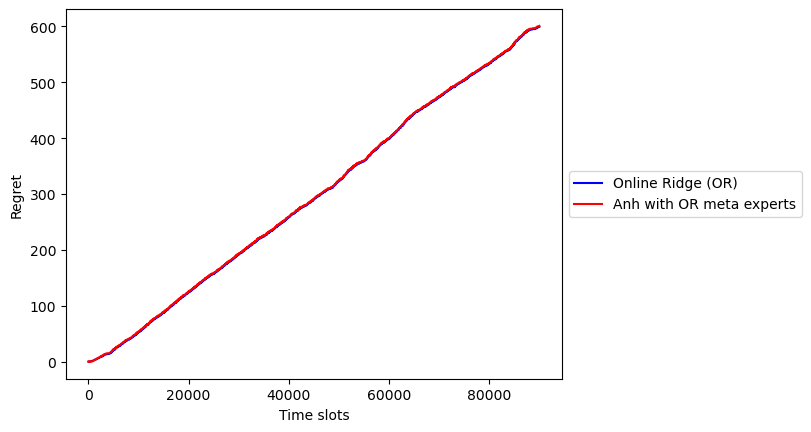

Group number 10, Tg is 153844 

    oridge end regret 1697.53, Anh end regret 1696.88, 

    Anh better Yes 


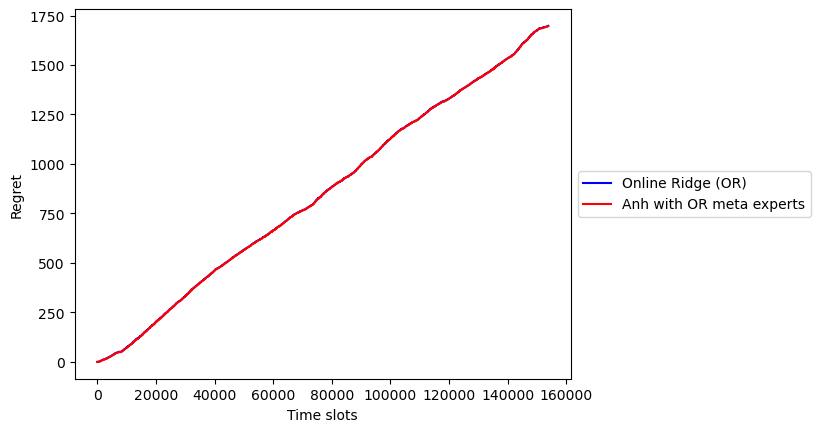

Group number 11, Tg is 1428283 

    oridge end regret 18057.70, Anh end regret 17233.12, 

    Anh better Yes 


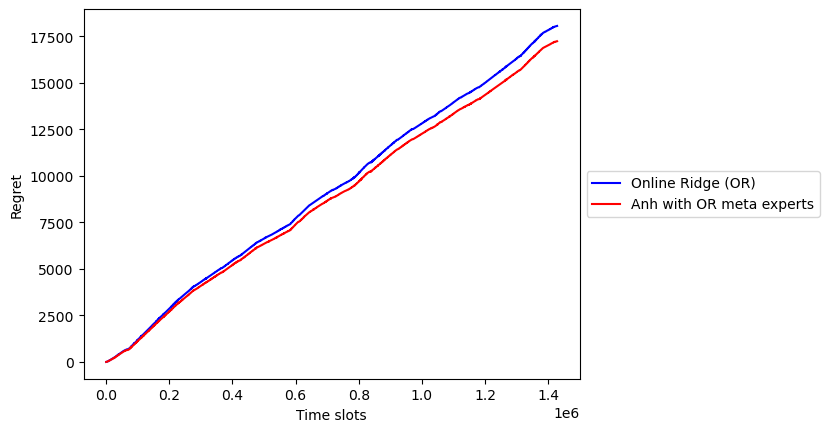

Anh better for 8 out of 12 groups


In [75]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_plusone) # testing the plotting with bestsq loss new class, smaller in memory

Group number 0, Tg is 722240 

    oridge end regret 9437.46, Anh end regret 9436.65, 

    Anh better Yes 


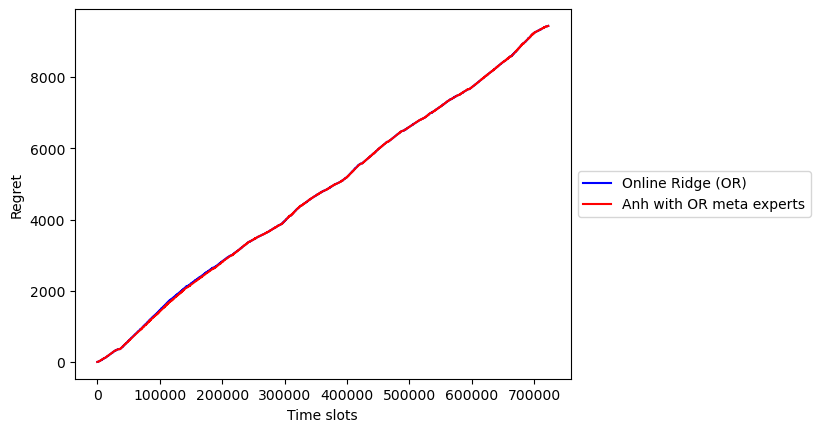

Group number 1, Tg is 706043 

    oridge end regret 8167.72, Anh end regret 8015.68, 

    Anh better Yes 


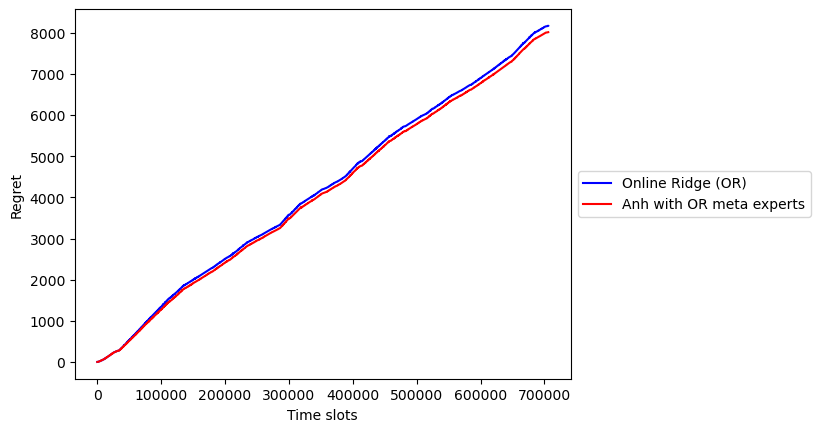

Group number 2, Tg is 948630 

    oridge end regret 12378.26, Anh end regret 12108.70, 

    Anh better Yes 


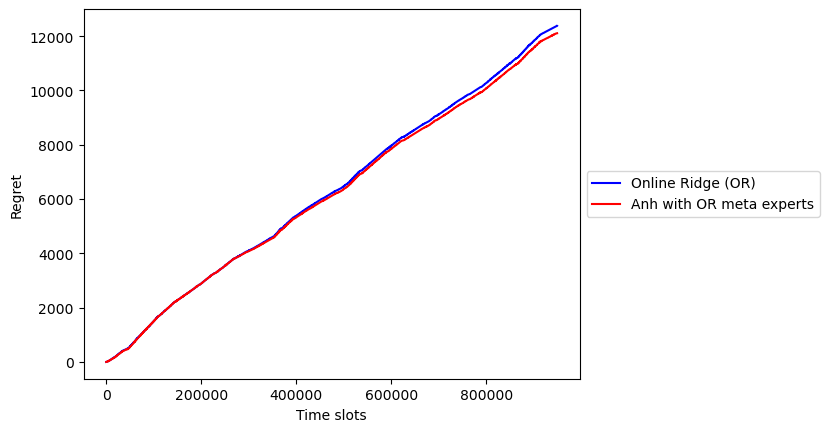

Group number 3, Tg is 124853 

    oridge end regret 977.35, Anh end regret 977.09, 

    Anh better Yes 


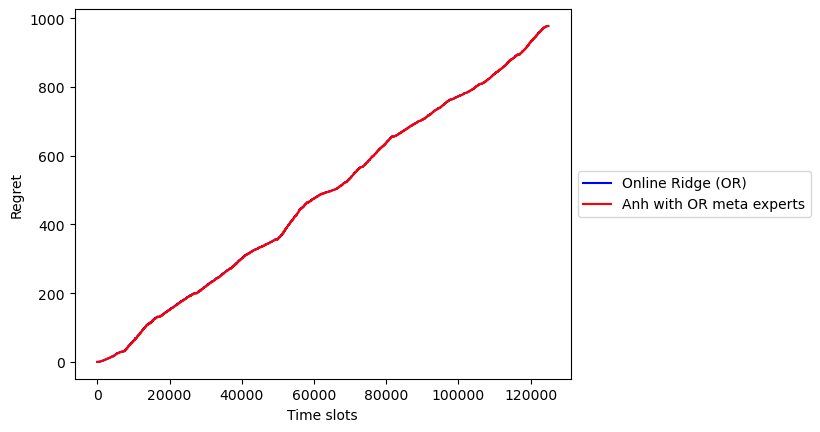

Group number 4, Tg is 13066 

    oridge end regret 71.09, Anh end regret 71.85, 

    Anh better No 


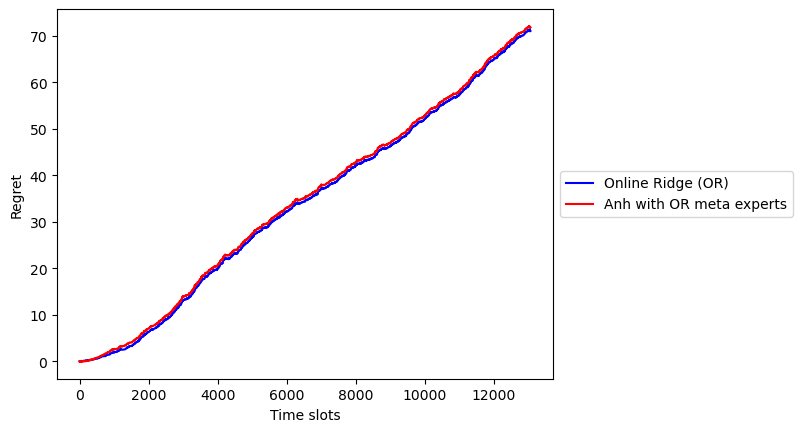

Group number 5, Tg is 613 

    oridge end regret 1.25, Anh end regret 1.42, 

    Anh better No 


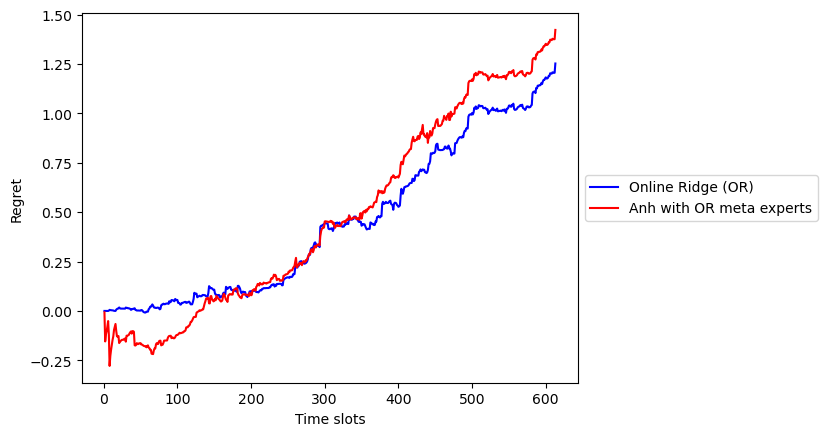

Group number 6, Tg is 2110 

    oridge end regret 7.99, Anh end regret 7.77, 

    Anh better Yes 


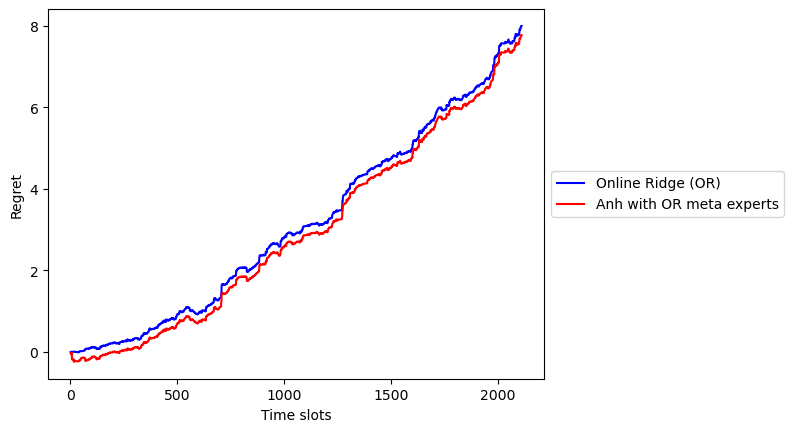

Group number 7, Tg is 92707 

    oridge end regret 1756.06, Anh end regret 1757.50, 

    Anh better No 


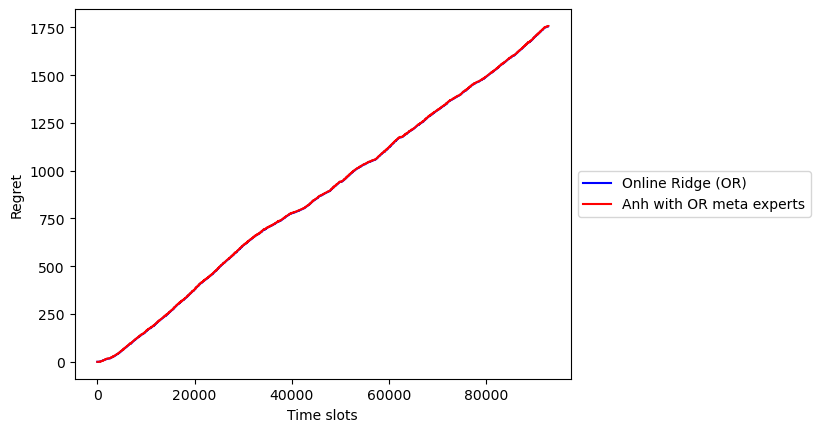

Group number 8, Tg is 2486 

    oridge end regret 9.01, Anh end regret 8.75, 

    Anh better Yes 


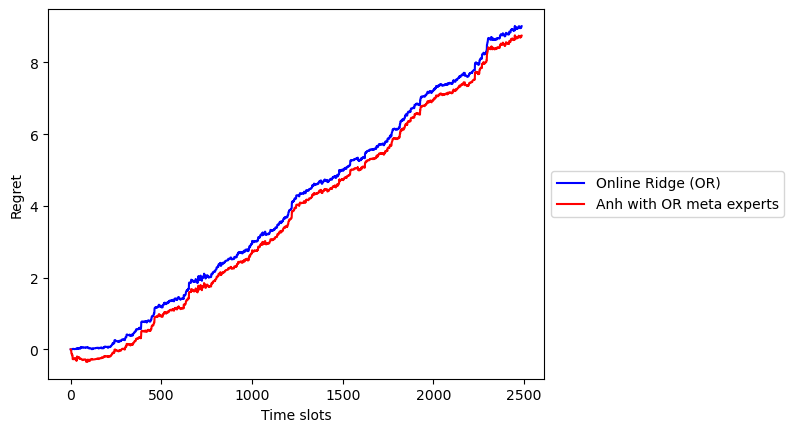

Group number 9, Tg is 89974 

    oridge end regret 599.45, Anh end regret 601.01, 

    Anh better No 


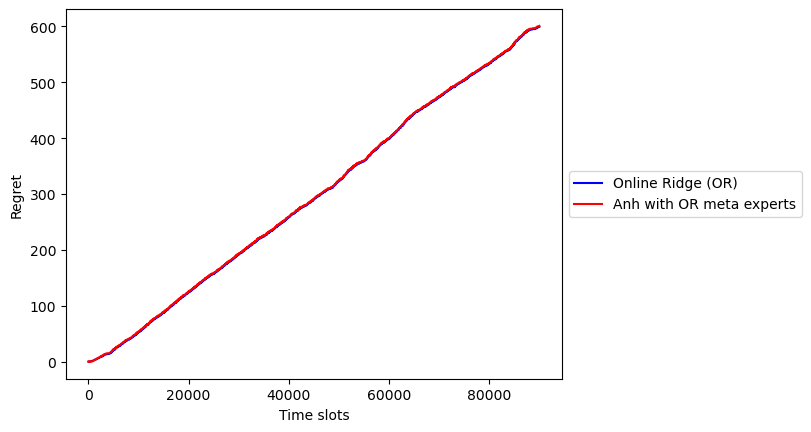

Group number 10, Tg is 153844 

    oridge end regret 1697.53, Anh end regret 1696.88, 

    Anh better Yes 


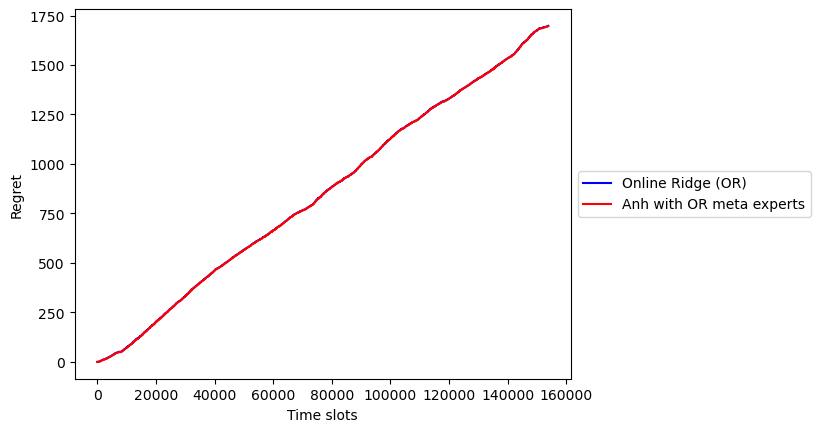

Group number 11, Tg is 1428283 

    oridge end regret 18057.70, Anh end regret 17233.12, 

    Anh better Yes 


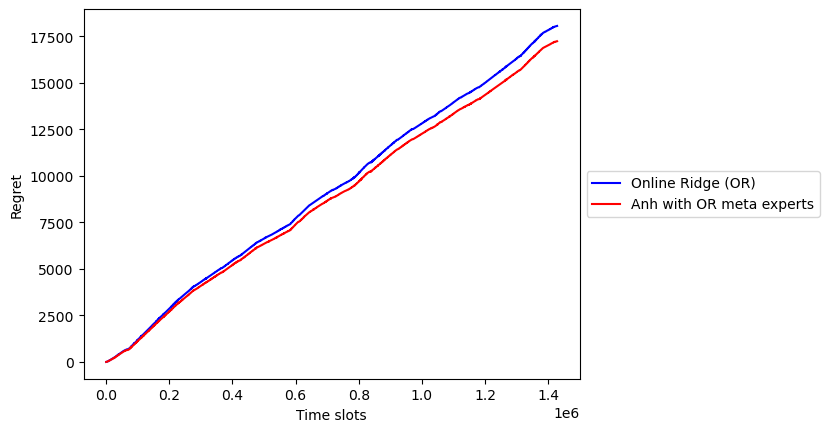

Anh better for 8 out of 12 groups


In [61]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_plusone)

In [12]:
X_dat_dropped = X_dat.drop(gnames, axis=1)

In [15]:
X_dat_dropped

,AGEP,WKHP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,...,OCCP_9130,OCCP_9142,OCCP_9150,OCCP_9600,OCCP_9610,OCCP_9620,OCCP_9640,OCCP_9645,OCCP_9825,OCCP_9830
0,0.025316,0.295918,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.037975,0.397959,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.025316,0.173469,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.215190,0.051020,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.025316,0.091837,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,0.291139,0.397959,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630163,0.379747,0.397959,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630164,0.367089,0.397959,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630165,0.063291,0.295918,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
y_dat

,PINCP
0,0.039472
1,0.030967
2,0.030467
3,0.053479
4,0.009455
...,...
1630162,0.399670
1630163,0.299615
1630164,0.092501
1630165,0.060483


In [43]:
bls = joblib.load('bls_together_joblib.pkl')
bls.cumbestsqloss()

In [47]:
joblib.dump(bls, 'bls_together_plusone_dropped.pkl')

['bls_together_plusone_dropped.pkl']

In [48]:
bls_undrop = joblib.load('bls_together_undroppedjoblib.pkl')

In [51]:
bestsqloss_arr[11]  - bls_undrop.best_sqloss[11] #is the same thats good

array([0., 0., 0., ..., 0., 0., 0.])

# now plotting Anh vs online ridge on dropped dataframe, including the always active meta expert 

In [80]:
bls_drop = joblib.load('bls_together_plusone_dropped.pkl')

In [79]:
with open('Anh_plus_alwaysactive_dropped.pkl', 'rb') as f:
    Anh_plus_dropped = pickle.load(f)

In [81]:
cumloss_groupwise_ridgesubseq = [] # for the new object, bls dropped!
cumreg_groupwise_ridgesubseq = [] # finding regret for oridge experts

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_plus_dropped.experts[gnum].loss_tarr))
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_drop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [82]:
Anh_plus_dropped.build_cumloss_curve(bls_drop.best_sqloss, A_tarr_plus)

Group number 0, Tg is 722240 

    oridge end regret 9684.84, Anh end regret 9684.06, 

    Anh better Yes 


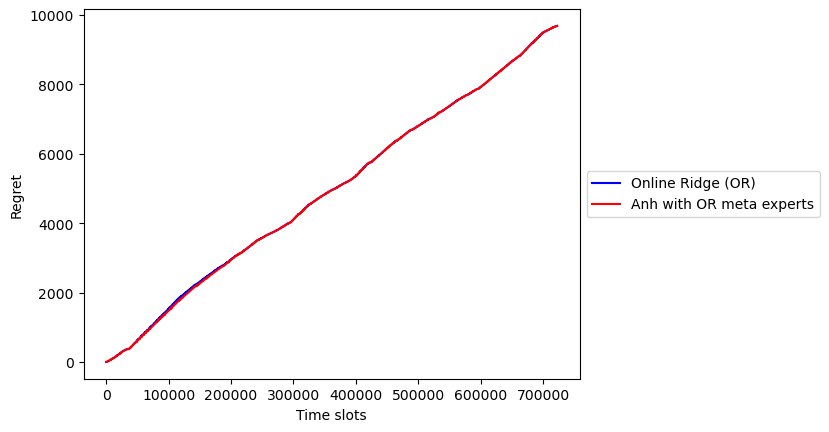

Group number 1, Tg is 706043 

    oridge end regret 8231.35, Anh end regret 8230.93, 

    Anh better Yes 


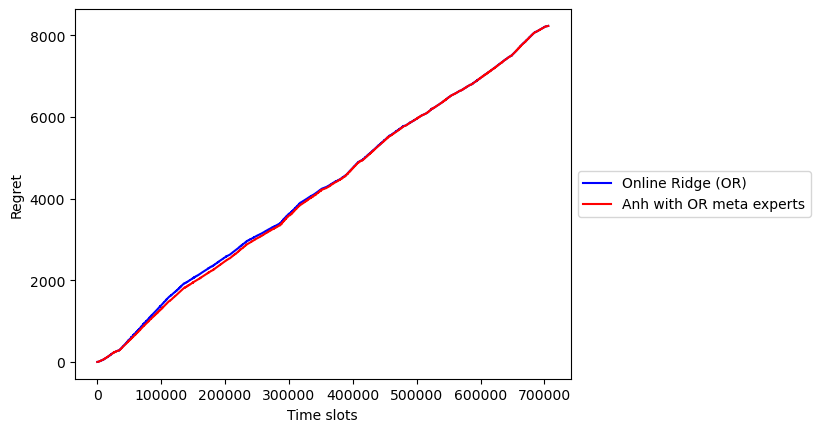

Group number 2, Tg is 948630 

    oridge end regret 13017.62, Anh end regret 12064.85, 

    Anh better Yes 


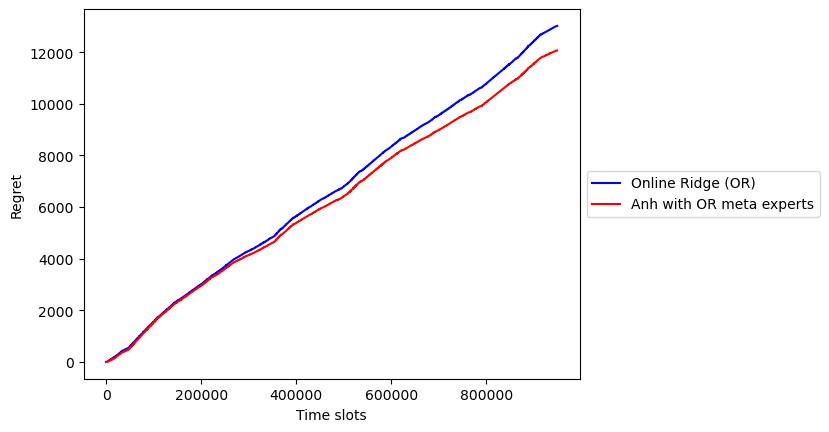

Group number 3, Tg is 124853 

    oridge end regret 976.06, Anh end regret 978.14, 

    Anh better No 


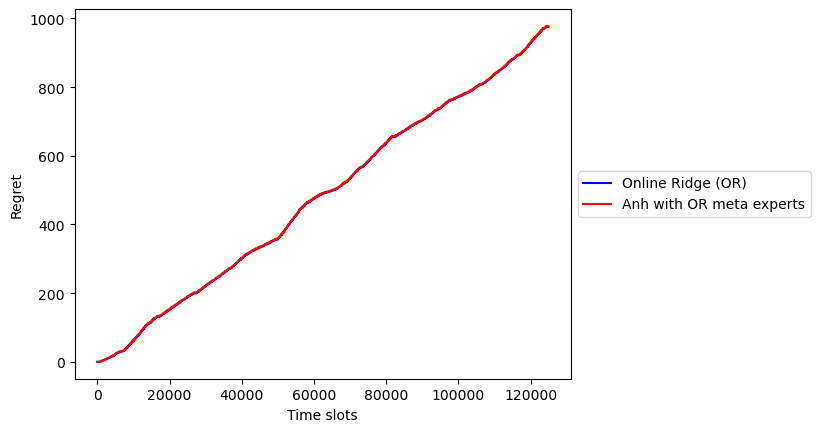

Group number 4, Tg is 13066 

    oridge end regret 72.69, Anh end regret 72.93, 

    Anh better No 


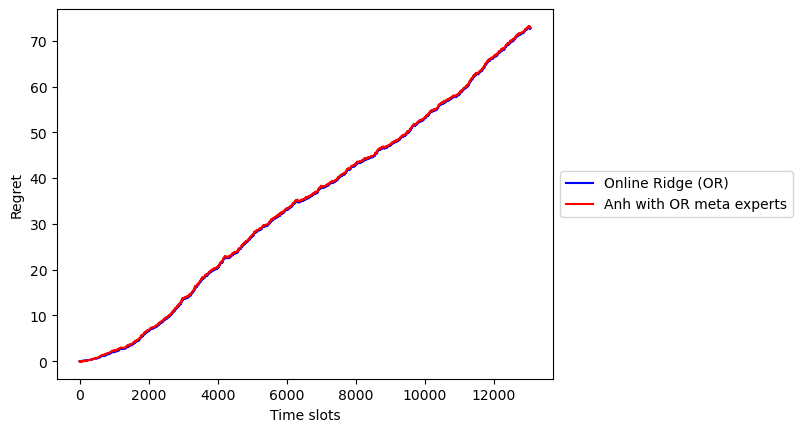

Group number 5, Tg is 613 

    oridge end regret 1.35, Anh end regret 1.78, 

    Anh better No 


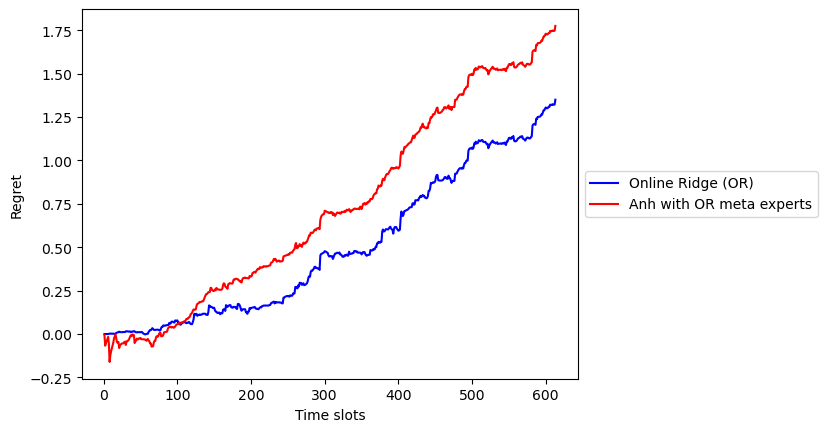

Group number 6, Tg is 2110 

    oridge end regret 8.30, Anh end regret 8.02, 

    Anh better Yes 


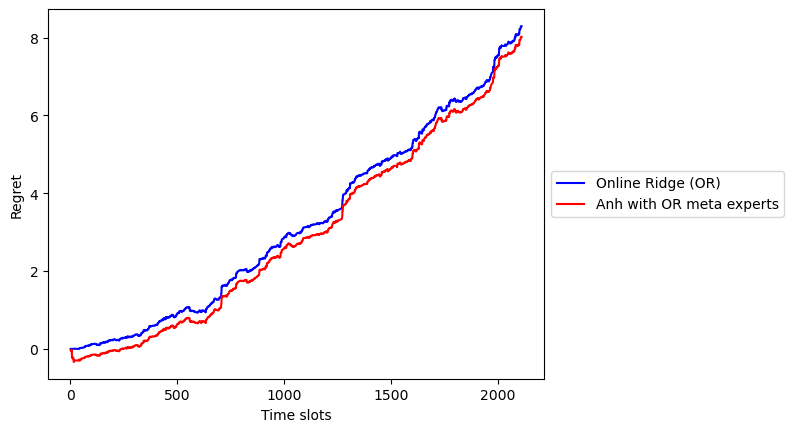

Group number 7, Tg is 92707 

    oridge end regret 1801.83, Anh end regret 1801.38, 

    Anh better Yes 


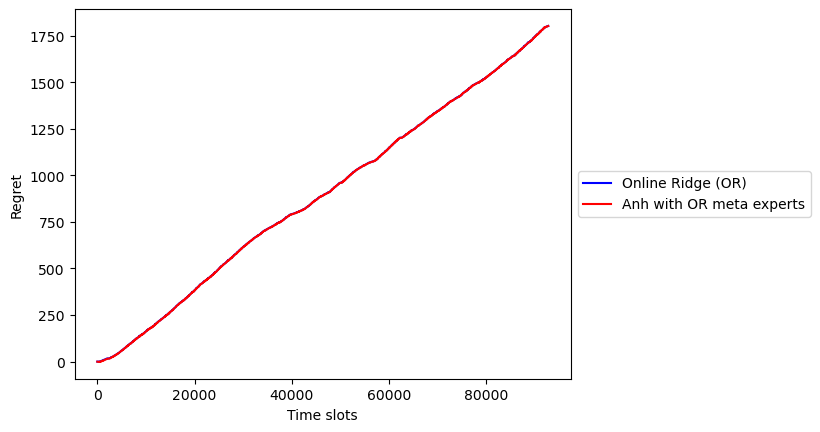

Group number 8, Tg is 2486 

    oridge end regret 9.47, Anh end regret 9.15, 

    Anh better Yes 


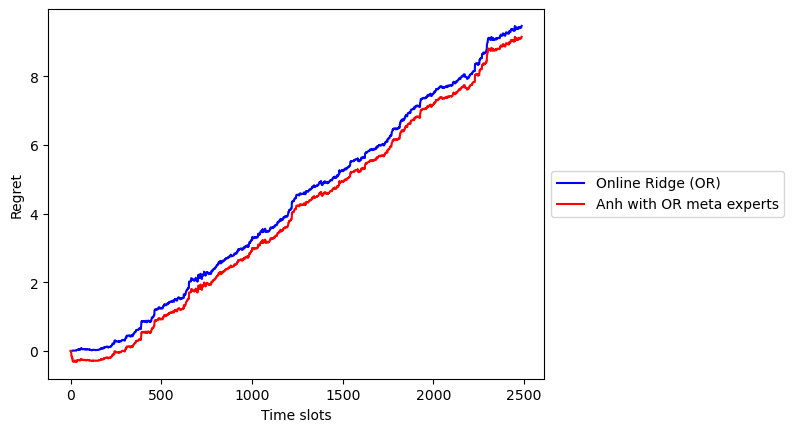

Group number 9, Tg is 89974 

    oridge end regret 616.79, Anh end regret 617.65, 

    Anh better No 


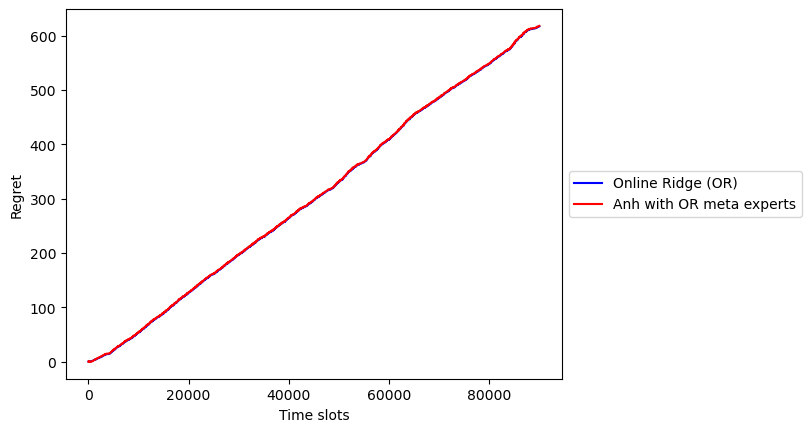

Group number 10, Tg is 153844 

    oridge end regret 1735.73, Anh end regret 1735.66, 

    Anh better Yes 


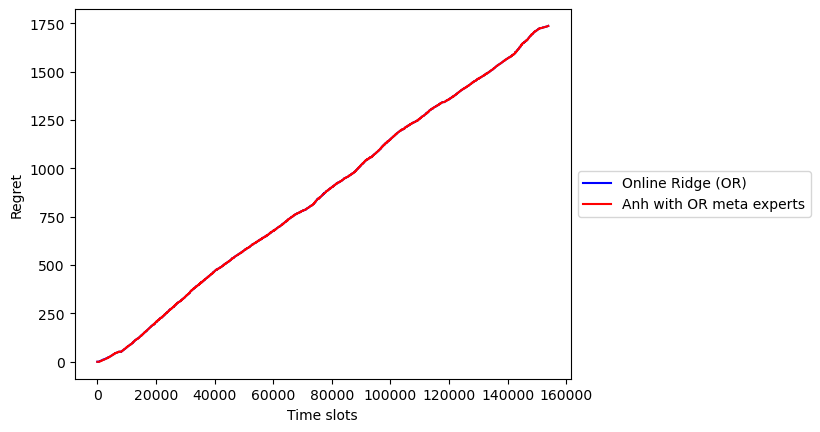

Group number 11, Tg is 1428283 

    oridge end regret 19263.90, Anh end regret 17228.97, 

    Anh better Yes 


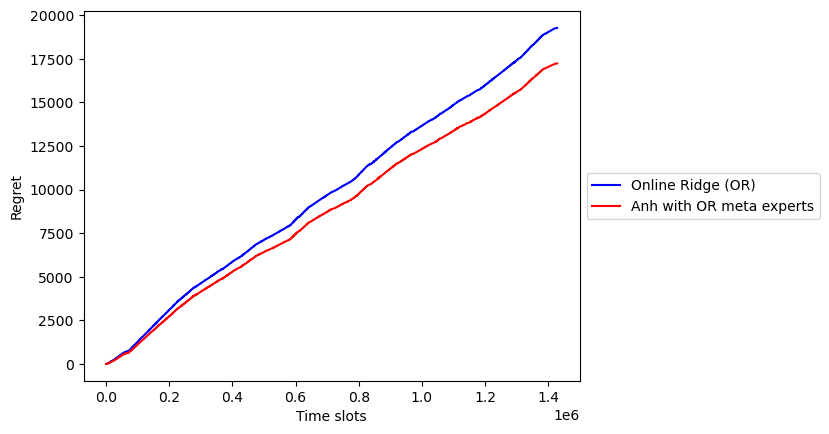

Anh better for 8 out of 12 groups


In [83]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_plus_dropped) # testing the plotting with bestsq loss new class, smaller in memory

In [85]:
# Comparing with online ridge which runs always, the implementable algorithm! 11 groups only here now
with open('loss_oridge_all_alwaysactive.pkl', 'rb') as f:
    loss_tarr = pickle.load(f)

loss_groupwise_oridge = []
cumloss_groupwise_oridge = []
cumreg_groupwise_oridge = []
loss_oridge_tarr = np.array(loss_tarr)

for gnum in range(11): # build cumulative loss for  on each group subsequence
    loss_groupwise_oridge.append(loss_oridge_tarr[A_tarr[:, gnum].astype(bool)]) # select those losses where group gnum active
    cumloss_groupwise_oridge.append(np.cumsum(loss_groupwise_oridge[-1])) #cumulative sum of the previous
    cumreg_groupwise_oridge.append(cumloss_groupwise_oridge[-1] - np.array(bestsqloss_arr[gnum])) #bestsquare loss for that group subsequence still the same

Group number 0, Tg is 722240 

    oridge end regret 28798.18, Anh end regret 9436.65, 

    Anh better Yes 


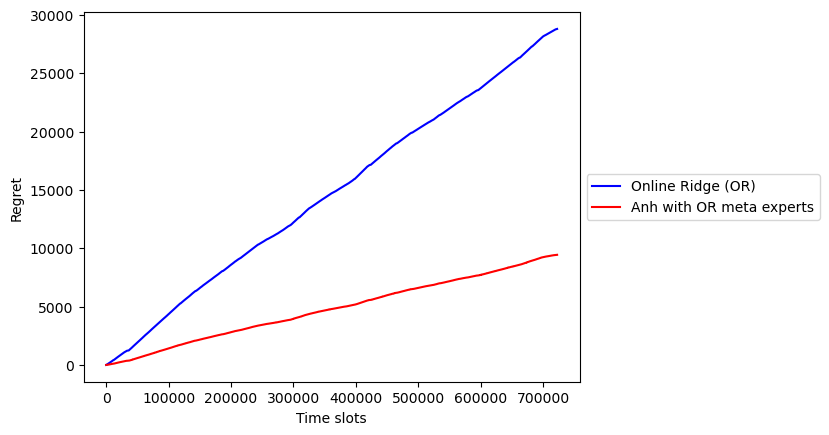

Group number 1, Tg is 706043 

    oridge end regret 20833.83, Anh end regret 8015.68, 

    Anh better Yes 


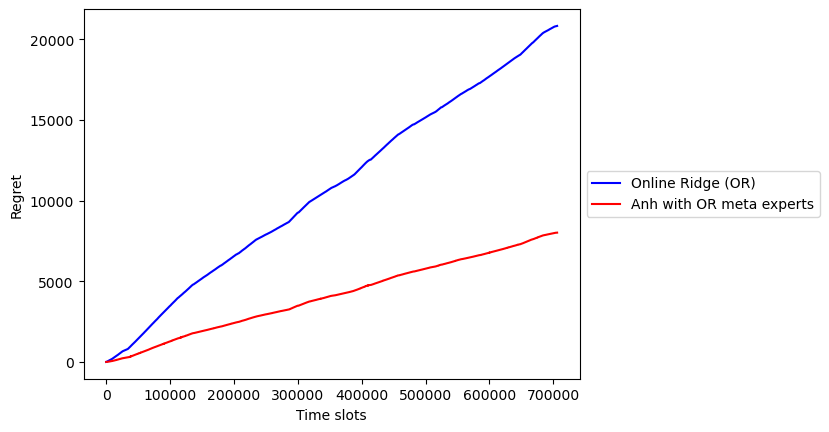

Group number 2, Tg is 948630 

    oridge end regret 34625.46, Anh end regret 12108.70, 

    Anh better Yes 


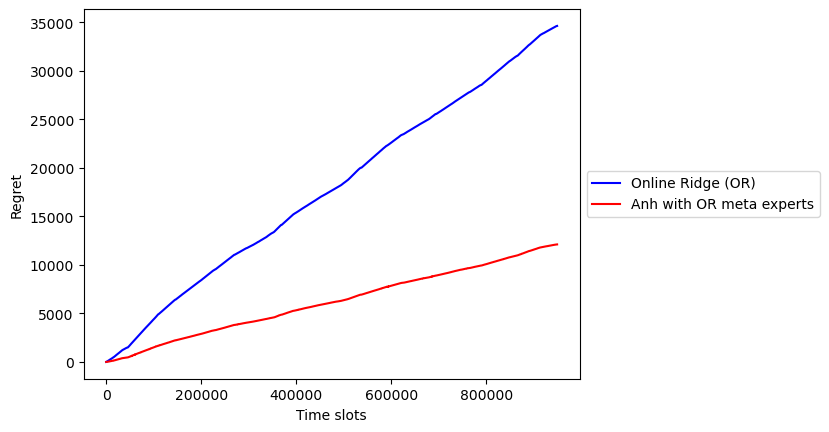

Group number 3, Tg is 124853 

    oridge end regret 3088.49, Anh end regret 977.09, 

    Anh better Yes 


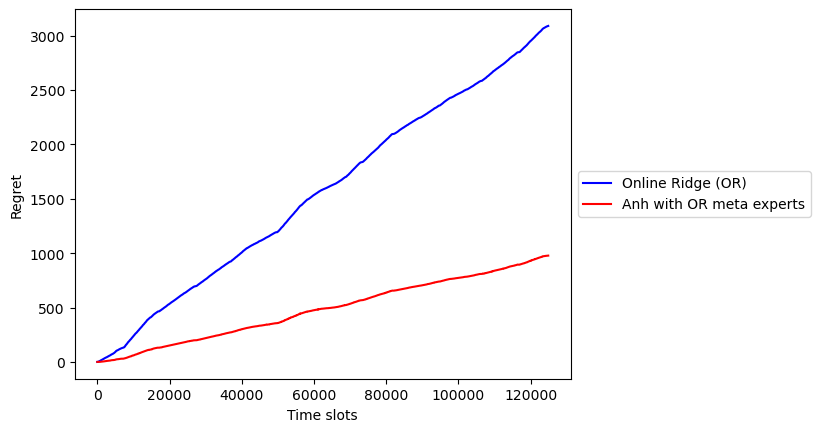

Group number 4, Tg is 13066 

    oridge end regret 304.66, Anh end regret 71.85, 

    Anh better Yes 


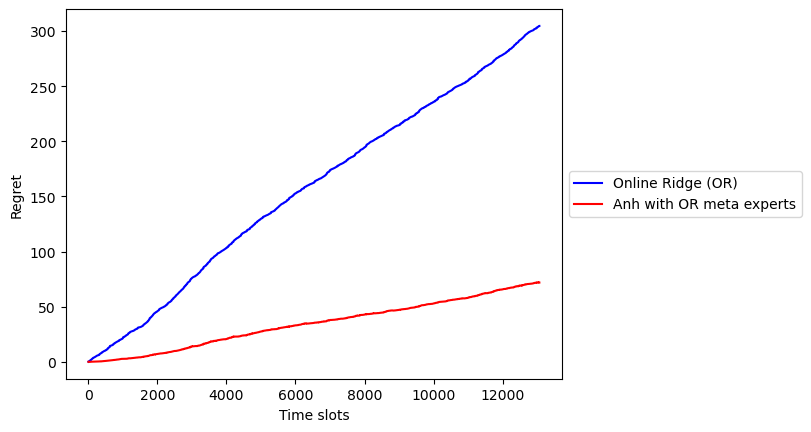

Group number 5, Tg is 613 

    oridge end regret 17.16, Anh end regret 1.42, 

    Anh better Yes 


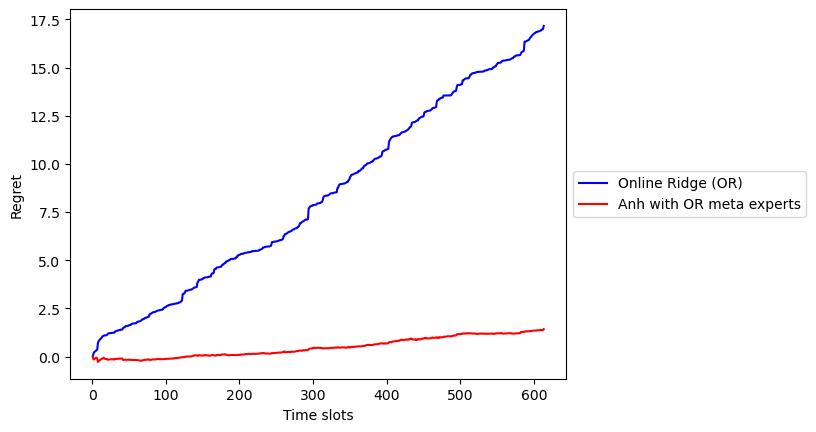

Group number 6, Tg is 2110 

    oridge end regret 51.89, Anh end regret 7.77, 

    Anh better Yes 


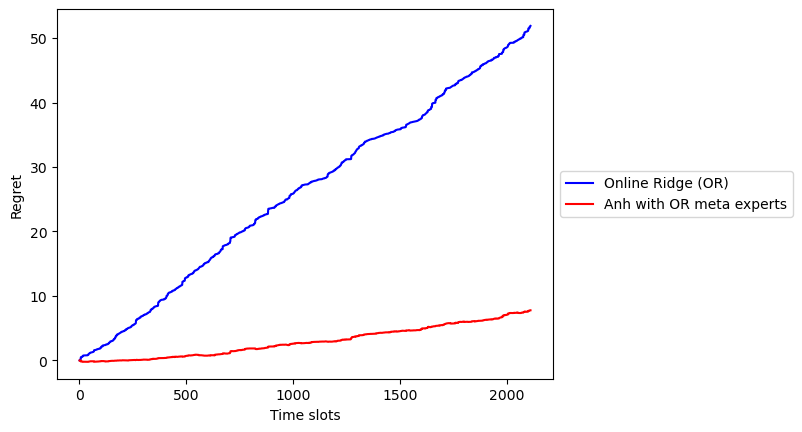

Group number 7, Tg is 92707 

    oridge end regret 4770.41, Anh end regret 1757.50, 

    Anh better Yes 


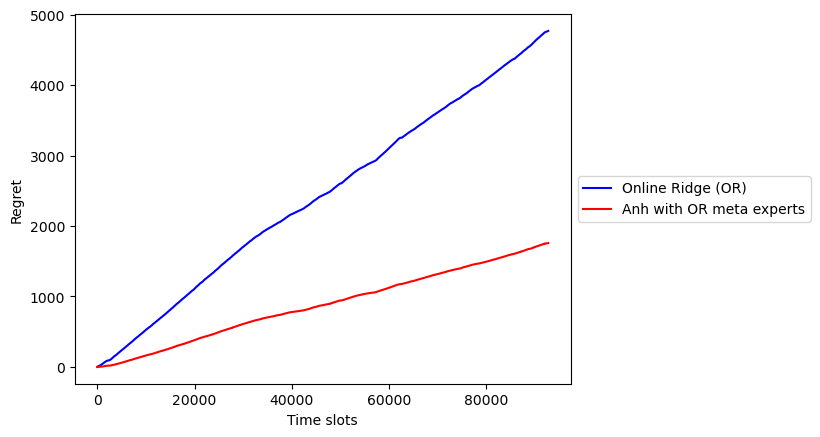

Group number 8, Tg is 2486 

    oridge end regret 68.25, Anh end regret 8.75, 

    Anh better Yes 


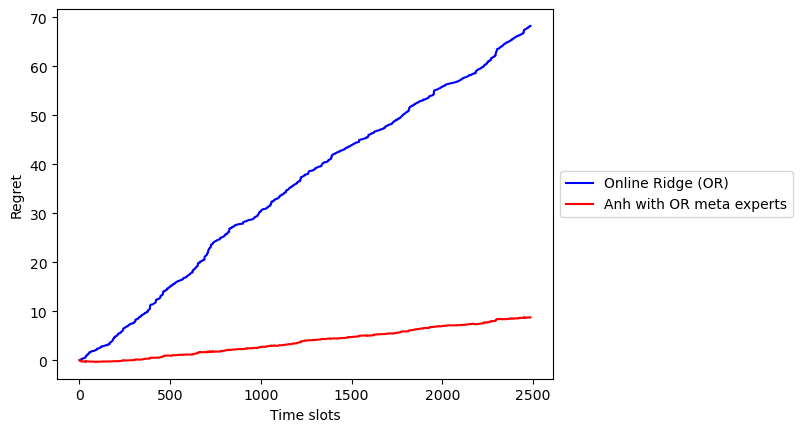

Group number 9, Tg is 89974 

    oridge end regret 2069.00, Anh end regret 601.01, 

    Anh better Yes 


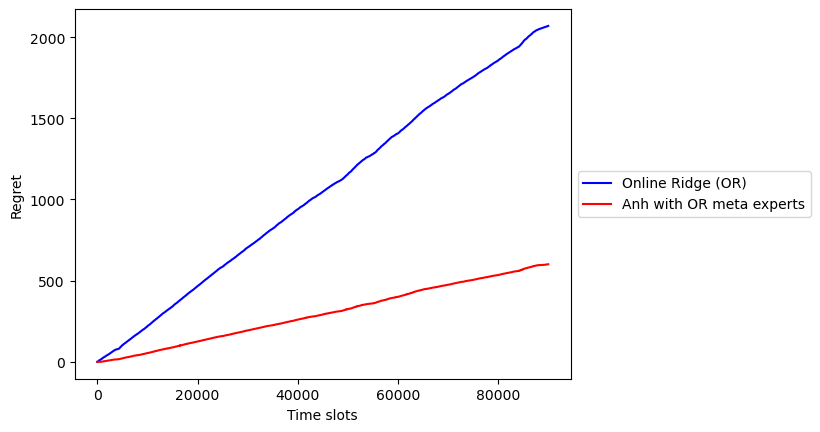

Group number 10, Tg is 153844 

    oridge end regret 4636.68, Anh end regret 1696.88, 

    Anh better Yes 


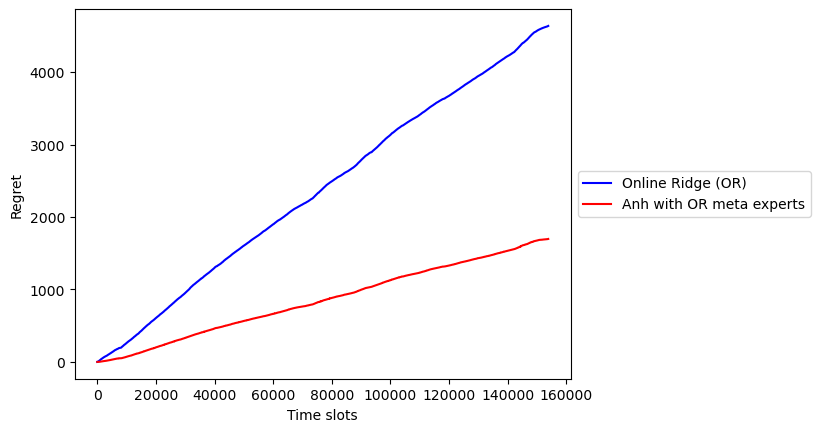

Anh better for 11 out of 12 groups


In [86]:
plot_ORidgevsAnh_together(cumloss_groupwise_oridge, Anh_plusone) 